# Zero-shot Food Classification
# Project Overview:
The objective of this track is to do zero shot classification for food types on previously unseen data. This is to be done by using CLIP(https://openai.com/blog/clip/). Work on food classification has been done by previous cohorts(https://fellowshipai.wordpress.com/raw-food-identification/), but we have found the following limitations with the approaches used:

1. They require a huge amount of resources(both in time as well as manpower) to annotate the data.
2. These algorithms are not able to generalize well to images that is not setup in the same setting as the data that model was trained upon.
3. They do not work on food types that are not present in the provided labels, hence requiring more resources with the increase with changes and updates to the application.

CLIP provides a way to overcome the said issues by using data that is freely available on the internet, without having to need a any sort of manual annotation. As we are free to use a large amount of data, the algorithm will be able to generalize better than a standard ResNet model to any kind of changes in how the image is presented and the final set of labels for prediction can be incremented as required without any extra work.
## Application:

The developed algorithm will be used to detect in-oven food types on the go and process them accordingly. With a robust zero-shot classification mechanism, the amount of manual work required to update the models periodically and label them can be mitigated by a huge amount. It might also help detect and classify multiple food types in case they are present in the image, depending on the type of decoder that will be used.

## Tasks:

The tasks in this track will be divided into two categories, the first will pertain to application and understanding of how CLIP works and in the second task, we will try to delve deeper into the research used and work on creating a general purpose algorithm.

1. Apply and test CLIP for existing in-oven food classification task
2. Work and build on the methodologies used in CLIP and other similar papers to create a more efficient zero shot classification algorithm that does not require huge amount of resources (data and compute) and is able to produce robust results on unseen data.

# 1. Import CLIP and other dependencies

In [ ]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

CUDA version: 10.1


In [ ]:
!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

import numpy as np
import torch

print("Torch version:", torch.__version__)

import matplotlib.pyplot as plt

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4MB 22kB/s 
     |████████████████████████████████| 12.8MB 53.4MB/s 
     |████████████████████████████████| 71kB 3.1MB/s 
  Created wheel for ftfy: filename=ftfy-5.8-cp36-none-any.whl size=45613 sha256=0fa24795967b83610bb00af824adf3745b8b598148faafc63e4ca533b6a5b47a
  Stored in directory: /root/.cache/pip/wheels/ba/c0/ef/f28c4da5ac84a4e06ac256ca9182fc34fa57fefffdbc68425b
Successfully built ftfy
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101
Torch version: 1.7.1+cu101


In [ ]:
#clone the CLIP repository
!git clone https://github.com/openai/CLIP.git
%cd CLIP

Cloning into 'CLIP'...
remote: Enumerating objects: 24, done.
remote: Total 24 (delta 0), reused 0 (delta 0), pack-reused 24
Unpacking objects: 100% (24/24), done.
/content/CLIP


In [ ]:
import torch
import clip
from PIL import Image

if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

model, transform = clip.load("ViT-B/32", device=device) #loading the clip checkpoints
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|██████████████████████| 353976522/353976522 [00:02<00:00, 149909655.70it/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [ ]:
! pip install ftfy regex
! wget https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz -O bpe_simple_vocab_16e6.txt.gz

--2021-01-18 17:13:29--  https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.13, 2620:1ec:bdf::13
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1356917 (1.3M) [application/octet-stream]
Saving to: ‘bpe_simple_vocab_16e6.txt.gz’

bpe_simple_vocab_16 100%[===================>]   1.29M  --.-KB/s    in 0.1s    

2021-01-18 17:13:29 (10.0 MB/s) - ‘bpe_simple_vocab_16e6.txt.gz’ saved [1356917/1356917]



# 2. Text encoder used in open.ai

In [ ]:
#@title

import gzip
import html
import os
from functools import lru_cache

import ftfy
import regex as re


@lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))


def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()


def whitespace_clean(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text


class SimpleTokenizer(object):
    def __init__(self, bpe_path: str = "bpe_simple_vocab_16e6.txt.gz"):
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        merges = gzip.open(bpe_path).read().decode("utf-8").split('\n')
        merges = merges[1:49152-256-2+1]
        merges = [tuple(merge.split()) for merge in merges]
        vocab = list(bytes_to_unicode().values())
        vocab = vocab + [v+'</w>' for v in vocab]
        for merge in merges:
            vocab.append(''.join(merge))
        vocab.extend(['<|startoftext|>', '<|endoftext|>'])
        self.encoder = dict(zip(vocab, range(len(vocab))))
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {'<|startoftext|>': '<|startoftext|>', '<|endoftext|>': '<|endoftext|>'}
        self.pat = re.compile(r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""", re.IGNORECASE)

    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token[:-1]) + ( token[-1] + '</w>',)
        pairs = get_pairs(word)

        if not pairs:
            return token+'</w>'

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        bpe_tokens = []
        text = whitespace_clean(basic_clean(text)).lower()
        for token in re.findall(self.pat, text):
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            bpe_tokens.extend(self.encoder[bpe_token] for bpe_token in self.bpe(token).split(' '))
        return bpe_tokens

    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors="replace").replace('</w>', ' ')
        return text

# 3. Download and extract food101 dataset.

In [ ]:
# Helper function to download data and extract
import os
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

In [ ]:
# Download data and extract it to folder
get_data_extract()

Streaming output truncated to the last 5000 lines.
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/553447.jpg
food-101/images/cannoli/

In [ ]:
import os
os.listdir('food-101/images')

['ceviche',
 'beignets',
 'spaghetti_bolognese',
 'caprese_salad',
 'foie_gras',
 'bruschetta',
 'tuna_tartare',
 'oysters',
 'samosa',
 'cannoli',
 'macarons',
 'seaweed_salad',
 'filet_mignon',
 'baklava',
 'greek_salad',
 'peking_duck',
 'hot_and_sour_soup',
 'strawberry_shortcake',
 'bibimbap',
 'lobster_roll_sandwich',
 'sashimi',
 'paella',
 'donuts',
 'apple_pie',
 'shrimp_and_grits',
 'beef_carpaccio',
 'red_velvet_cake',
 'carrot_cake',
 'grilled_cheese_sandwich',
 'waffles',
 'beef_tartare',
 'prime_rib',
 'beet_salad',
 'tiramisu',
 'chocolate_cake',
 'caesar_salad',
 'panna_cotta',
 'gyoza',
 'poutine',
 'ramen',
 'pork_chop',
 'edamame',
 'chicken_quesadilla',
 'sushi',
 'cheese_plate',
 'ravioli',
 'french_toast',
 'crab_cakes',
 'ice_cream',
 'cup_cakes',
 'grilled_salmon',
 'french_onion_soup',
 'guacamole',
 'falafel',
 'fried_calamari',
 'eggs_benedict',
 'chicken_curry',
 'pancakes',
 'croque_madame',
 'takoyaki',
 'frozen_yogurt',
 'lasagna',
 'club_sandwich',
 'ome

In [ ]:
os.listdir('food-101/meta')

['test.json',
 'test.txt',
 'classes.txt',
 'train.json',
 'labels.txt',
 'train.txt']

In [ ]:
# Helper method to split dataset into train and test folders
import numpy as np
from collections import defaultdict
import collections
import os
from shutil import copy
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [ ]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [ ]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [ ]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find food-101/train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [ ]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find food-101/test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


In [ ]:
# List of all 101 types of foods(sorted alphabetically)
categories = os.listdir('food-101/images')

# 4. Select images from Food-101 for predictions

In [ ]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions

descriptions = {
    "guacamole": "This is a photo of guacamole",
    "tacos": "this is photo of tacos",
    "hot_dogs": "this is a photo of hot dogs",
    "french_fries": "this is a photo of french fries",
    "clam_chowder": "this is a photo of clam chowder",
    "pork_chop": "this is a photo of pork chops",
    "chicken_curry": "this is a photo of chicken curry", 
    "pulled_pork_sandwich": "this is a photo of a pulled pork sandwich"
}

In [ ]:

from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image

preprocess = Compose([
    Resize(input_resolution, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor()
])
image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711])

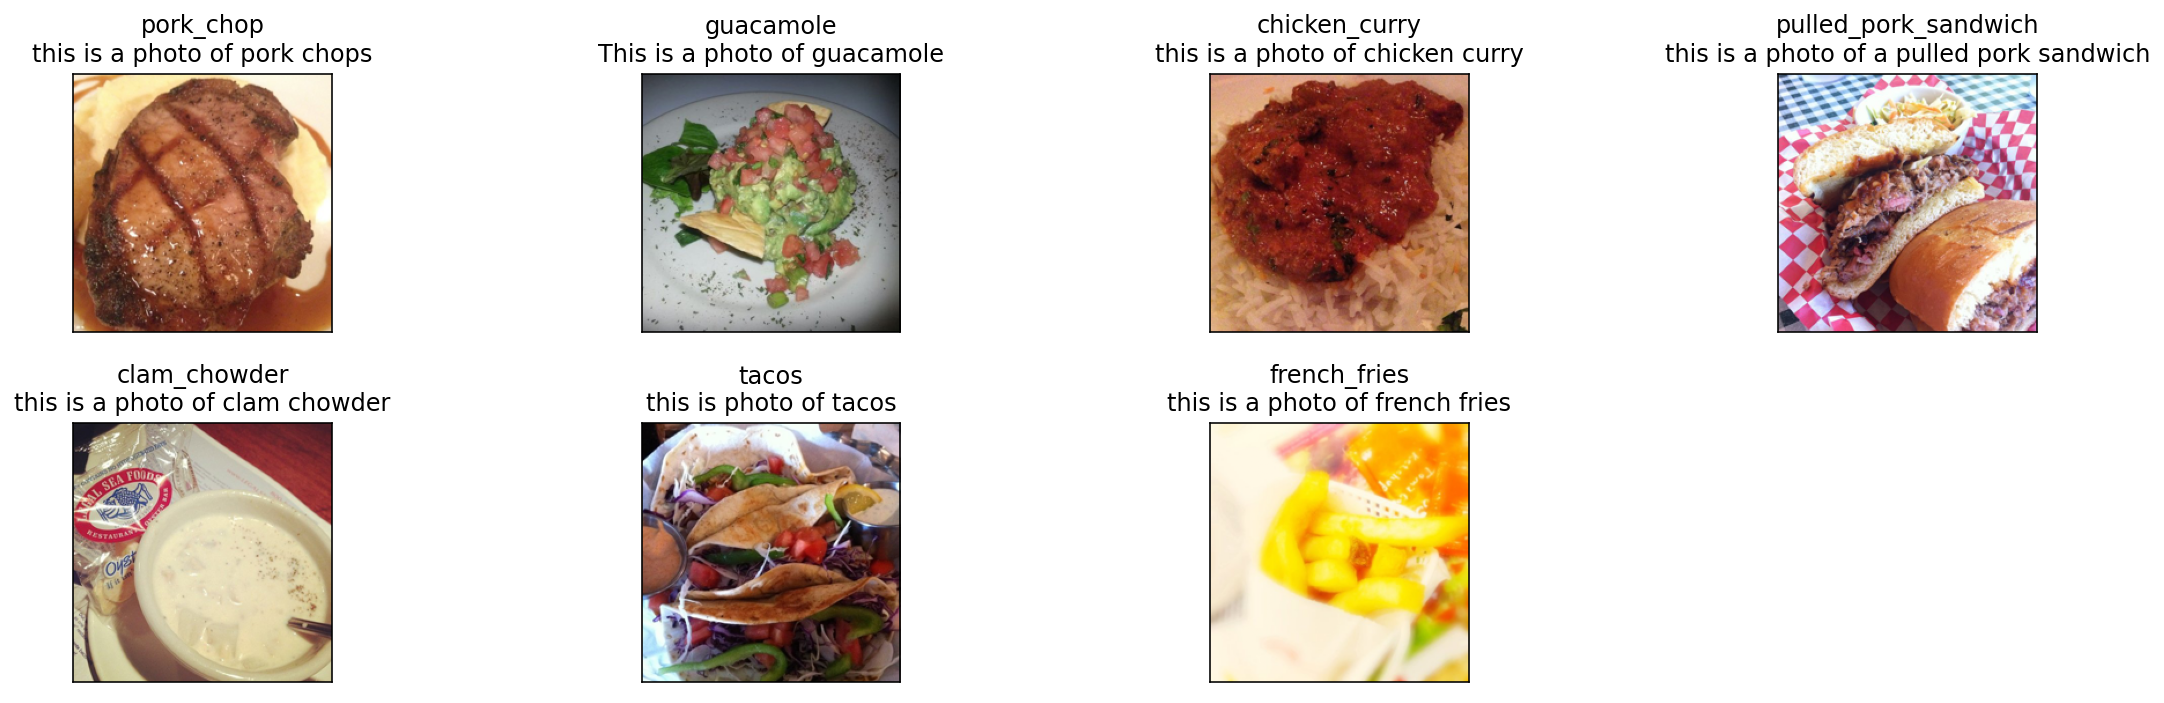

In [ ]:
images = []
texts = []
plt.figure(figsize=(16, 5))

for folder in os.listdir('food-101/train/'):
  for filename in [(i, filename) for i, filename in enumerate(os.listdir('food-101/train/' + folder )) if filename.endswith(".png") or filename.endswith(".jpg") and i == 0]:
    if folder not in descriptions:
      continue
    image = preprocess(Image.open(os.path.join('food-101/train', folder, filename[1])).convert("RGB"))
    images.append(image)
    texts.append(descriptions[folder])

    plt.subplot(2, 4, len(images))
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"{folder}\n{descriptions[folder]}")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

In [ ]:
image_input = torch.tensor(np.stack(images))
image_input -= image_mean[:, None, None]
image_input /= image_std[:, None, None]

In [ ]:
tokenizer = SimpleTokenizer()
text_tokens = [tokenizer.encode("This is " + desc) for desc in texts]
text_tokens

[[589, 533, 589, 533, 320, 1125, 539, 7897, 26321],
 [589, 533, 589, 533, 320, 1125, 539, 40115],
 [589, 533, 589, 533, 320, 1125, 539, 3717, 8051],
 [589, 533, 589, 533, 320, 1125, 539, 320, 8525, 7897, 8687],
 [589, 533, 589, 533, 320, 1125, 539, 32598, 37886],
 [589, 533, 589, 533, 1125, 539, 14090],
 [589, 533, 589, 533, 320, 1125, 539, 3461, 11369]]

In [ ]:
tokenizer = SimpleTokenizer()
text_tokens = [tokenizer.encode("This is " + desc) for desc in texts]
text_tokens

[[589, 533, 589, 533, 320, 1125, 539, 7897, 26321],
 [589, 533, 589, 533, 320, 1125, 539, 40115],
 [589, 533, 589, 533, 320, 1125, 539, 3717, 8051],
 [589, 533, 589, 533, 320, 1125, 539, 320, 8525, 7897, 8687],
 [589, 533, 589, 533, 320, 1125, 539, 32598, 37886],
 [589, 533, 589, 533, 1125, 539, 14090],
 [589, 533, 589, 533, 320, 1125, 539, 3461, 11369]]

In [ ]:
text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)
sot_token = tokenizer.encoder['<|startoftext|>']
eot_token = tokenizer.encoder['<|endoftext|>']

for i, tokens in enumerate(text_tokens):
    tokens = [sot_token] + tokens + [eot_token]
    text_input[i, :len(tokens)] = torch.tensor(tokens)

text_input = text_input

In [ ]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_input).float()

In [ ]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

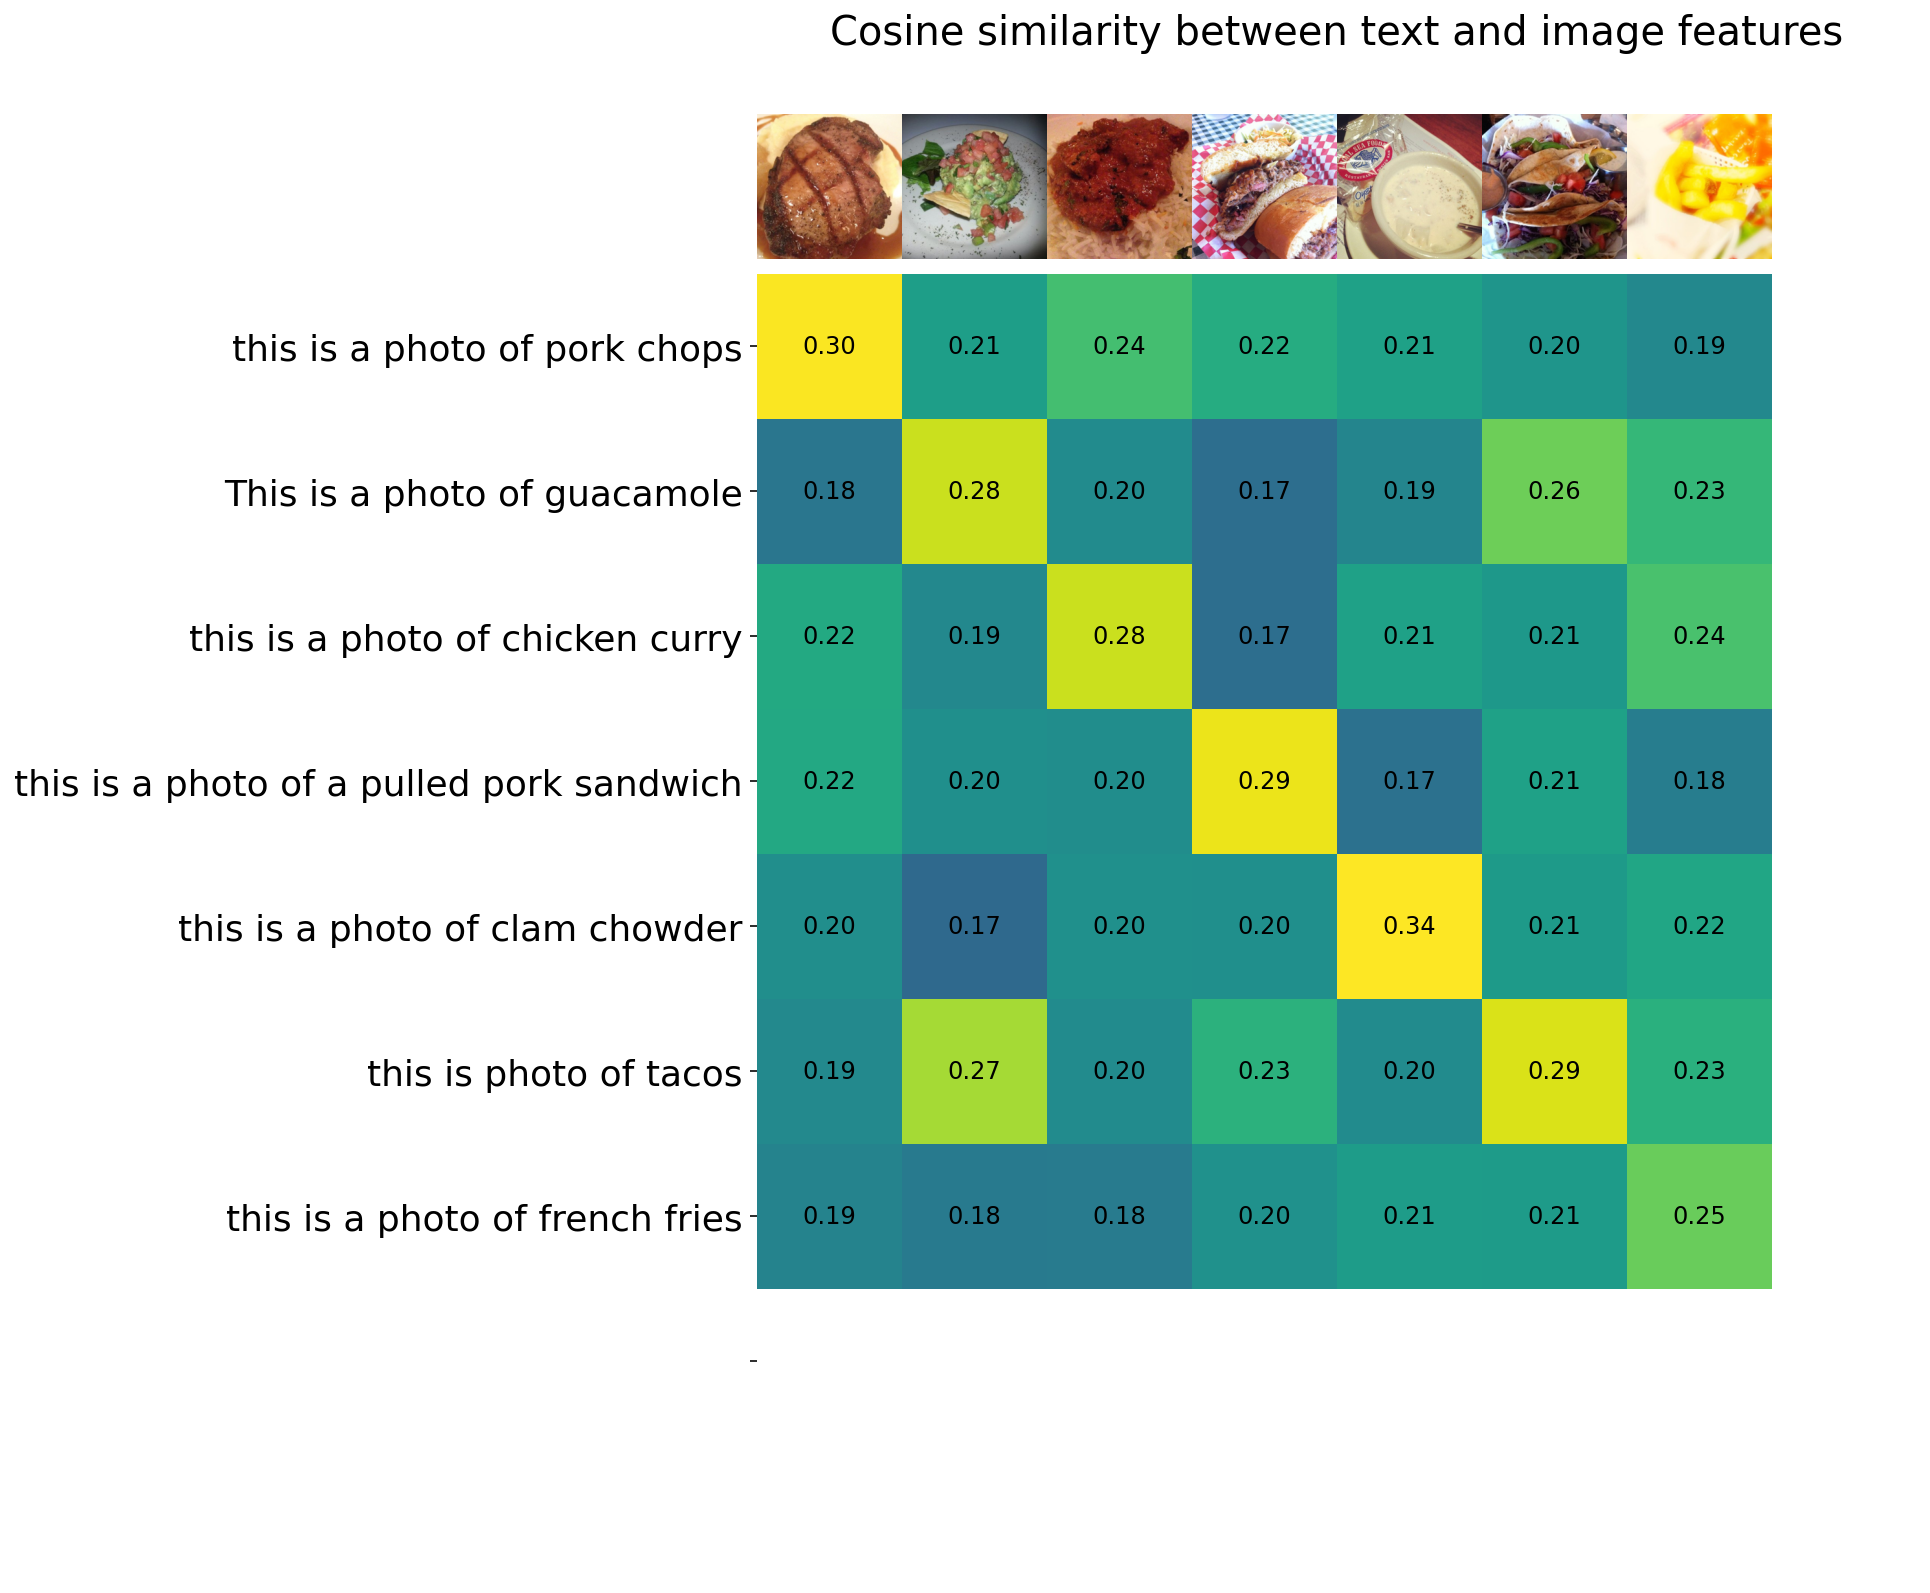

In [ ]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(images):
    plt.imshow(image.permute(1, 2, 0), extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import models, transforms, datasets

train_transforms = transforms.Compose([
    transforms.Resize(input_resolution, interpolation=Image.BICUBIC),
    transforms.CenterCrop(input_resolution),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.48145466, 0.4578275, 0.40821073],
        std=[0.26862954, 0.26130258, 0.27577711]
    )
])

valid_transforms = transforms.Compose([
    transforms.Resize(input_resolution, interpolation=Image.BICUBIC),
    transforms.CenterCrop(input_resolution),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.48145466, 0.4578275, 0.40821073],
        std=[0.26862954, 0.26130258, 0.27577711]
    )
])


In [ ]:
DIR_DATA = 'food-101/'
train_data = datasets.ImageFolder(os.path.join(DIR_DATA, 'train'), transform=train_transforms)
valid_data = datasets.ImageFolder(os.path.join(DIR_DATA, 'test'), transform=valid_transforms)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)

class_names = train_data.classes

In [ ]:
candidate_captions = train_data.classes
class_names = train_data.classes

In [ ]:
text_descriptions = [f"This is a photo of a {label}" for label in train_data.classes]
text_tokens = [[sot_token] + tokenizer.encode(desc) + [eot_token] for desc in text_descriptions]
text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)

for i, tokens in enumerate(text_tokens):
    text_input[i, :len(tokens)] = torch.tensor(tokens)

text_input = text_input
text_input.shape

torch.Size([101, 77])

In [ ]:
with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

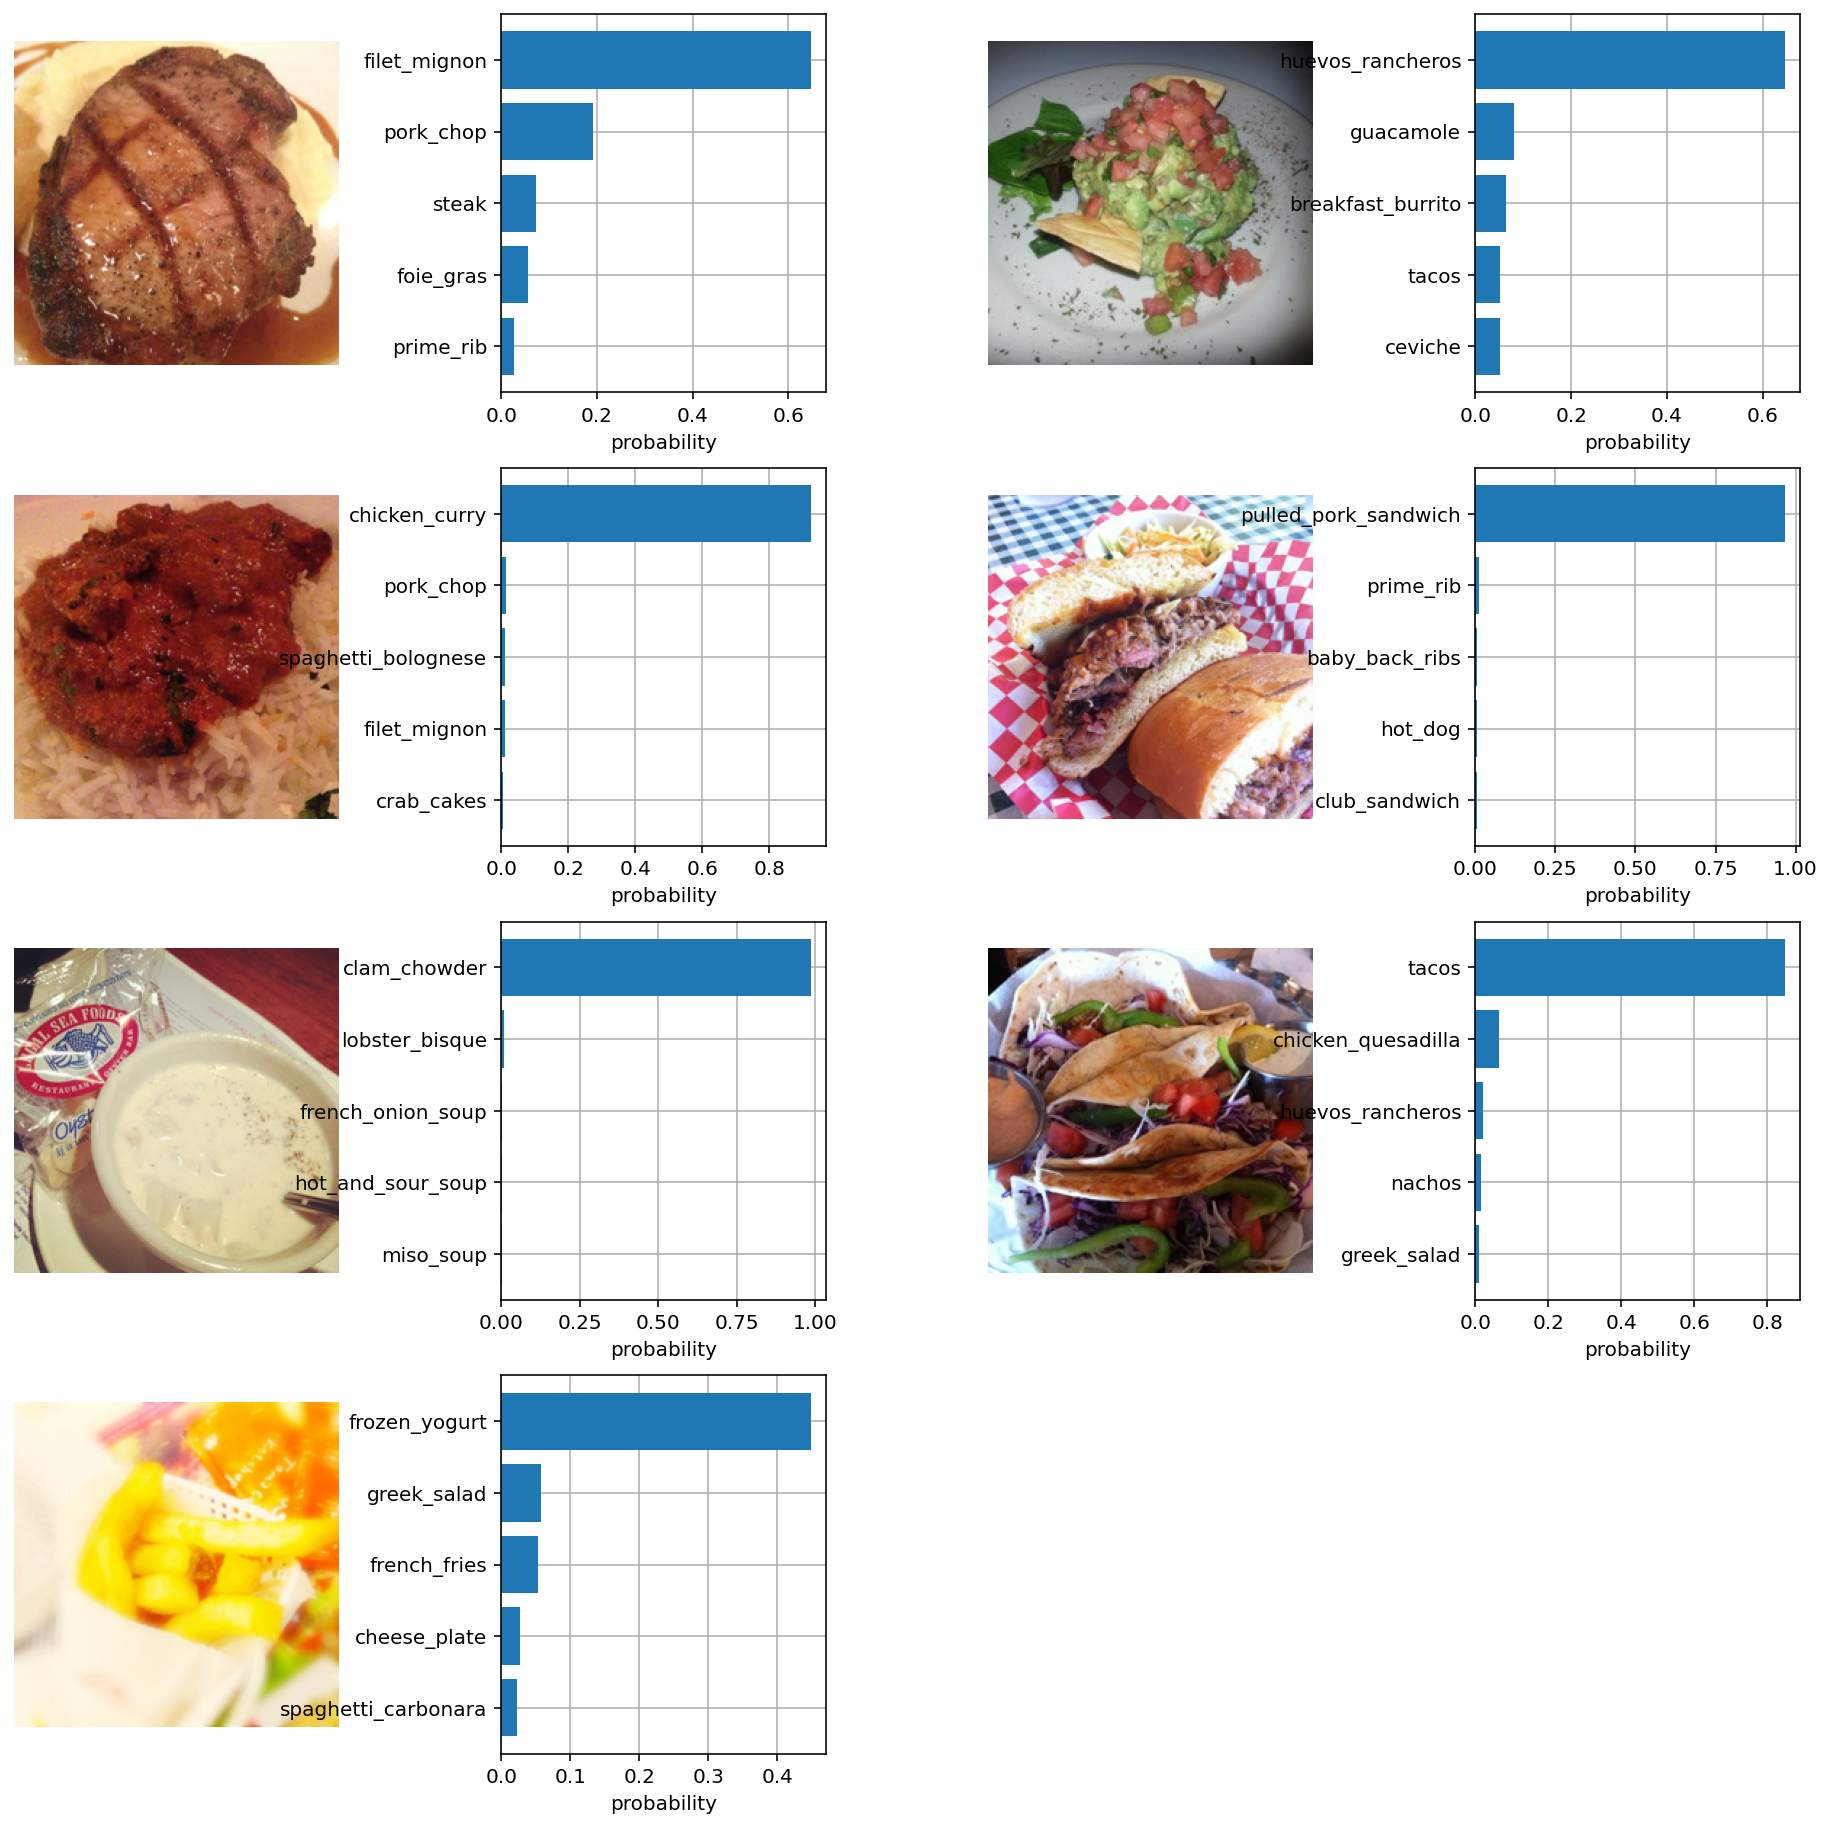

In [ ]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [train_data.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()